In [50]:
# IMPORTS
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# This prevents to restart the kernel whenever an external file is edited
%load_ext autoreload
%autoreload 2
# Matplotlib (could also use notebook option)
%matplotlib inline

# Custom modules
from src import viral_seq
from src import common
from src import setup

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introduction 

From `dictionary_viral_seq.txt` :
* Some NA are present when nucleotides had low coverage
* Nucleotide column format: `pos_position123_variant`
* Amino acid column format: `gene_genenameXYZ_pos_position123_variant`
* 0 indicates abscence of the variant, while 1 indicates its presence

## Notebook structure

1. Introduction
    1. Genetic background
1. Import data
    1. Visualize format
1. Data glimpse
    1. NAN values
    1. Mutation rates per individual
    1. Mutation rates per variant
    1. Mutation rates per position
1. Process NA values
    1. Per variant
    1. Per individual
1. PCA
    1. Imputation
    1. PCA and simple imputation
    1. PCA and iterative imputation

## Genetic background and geographical distribution

Article [*Genetic diversity of hepatitis B virus strains derived worldwide: genotypes, subgenotypes, and HBsAg subtypes.*](https://www.ncbi.nlm.nih.gov/pubmed/15564741).

A and F have two subgenotypes, also B, C and D are divided into 4 subgenotypes. 

* B1 dominating in Japan
* B2 in China and Vietnam
* B3 Indonesia
* B4 Vietnam
* C1 Japan, Korea, China
* C2 China,, South-East Asia, Bangladesh
* C3 Oceania
* C4 Aborigines from Autralia
* Less evident for D1-D4, spread in Europe, Africa, Asia (possibly diverged earlier than genotypes B and C).
* D4 being the first split and still the dominating subgenotype of D in Oceania.

Article *[The Molecular Pathology and Clinical Impact of HBV Genetic Variability]*:

High risk of developping hepatocellular carcinoma (HCC). Epidemiology of HCC is peculiar with both geographical and temporal patterns of incidence, paralleling exposure to viral etiologic factors. HBV genomes are **classified into 8 groups**, A to H, aving distinct geographical distributions. 

Article [Hepatitis B virus lineages in mammalian hosts: Potential for bidirectional cross-species transmission](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4069295/):

Among chronic hepatitis B carriers, ~ 75% live in Asia. First criterion of classification: based on the viral surface antigen (HBsAg). The determinant 'a' (HBsAg amino acid residues 124 to 147) is common to all HBV isolates. Residues 122 and 160 are used to classify the second and the third determinants. Their combination is used for determining HBV subtypes. The four major subtypes are further subdivided, adding up to a total of ten described subtypes: ayw1, ayw2, ayw3, ayw4, ayr, adw2, adw3, adw4q-, adrq+ and adrq.

Currently, HBV classification is based on viral genotypes and clades derived from phylogenetic analyses of partial or full-length nucleotide sequences. The nucleotide divergence must be of at least 7.5% for defining a genotype while a classification exclusively based on Surface gene requires at least 4% divergence. 8 different HBV genotypes have been described based on full-length sequences, A to H. Two others, I and J, are not consensually accepted yet. 

**Genotypes diverging between 4% and 7.5% are further subdivided into sub-genotypes**: A1-A5, B1-B8, C1-C7, D1-D7, F1-F4. D8 is under examination (Niger). Two F sub-genotypes are further divided in two clades F1 (a-d) and F2 (a-b). 

Geographical distribution:

* HBV/A and HBV/D are worldwide distributed
* HBV/B and HBV/C prevalent in Asia, Oceania, North America
* HBV/B Africa
* HBV/F Latin America
* HBV/G Central America, Europe
* HBV/H Central America.
* South America: A, D, F


# Import data



In [3]:
df_aa = pd.read_csv("data/viral_seq/OUT_aa_binary_table.txt", sep='\s+')
# We prefer to have integers than index to process data
# But we keep the provided index in case it will be useful later
df_aa.reset_index(inplace=True)
print(df_aa.shape)
df_aa.head()

(790, 5394)


,index,gene_PC_C_pos_0001_I,gene_PC_C_pos_0001_M,gene_PC_C_pos_0002_Q,gene_PC_C_pos_0002_R,gene_PC_C_pos_0002_STOP,gene_PC_C_pos_0003_L,gene_PC_C_pos_0004_F,gene_PC_C_pos_0005_H,gene_PC_C_pos_0006_L,...,gene_X_pos_0148_Y,gene_X_pos_0149_D,gene_X_pos_0149_N,gene_X_pos_0150_F,gene_X_pos_0151_F,gene_X_pos_0152_T,gene_X_pos_0153_S,gene_X_pos_0154_A,gene_X_pos_0155_STOP,gene_X_pos_0155_W
0,GS-US-174-0149-1884,0.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,1.0,...,0.0,0.0,1.0,NaN,NaN,1.0,1.0,1.0,1.0,0.0
1,GS-US-174-0149-2770,0.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,1.0,...,0.0,0.0,1.0,NaN,NaN,1.0,1.0,1.0,1.0,0.0
2,GS-US-174-0149-5008,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,0.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0
3,GS-US-174-0149-5014,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,0.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0
4,GS-US-174-0149-6637,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,0.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0


## Visualize format

In [4]:
def extract_values(df, n):
    cols = df.columns.values[1:] # we slice that way to avoid 'index' column
    lst = []
    for v in cols:
        lst.append(v.split('_')[n])
    # Remove duplicates
    lst = list(dict.fromkeys(lst))
    return lst

### Variants

In [5]:
lst = extract_values(df_aa, -1)
print("Variants ({} items): {}".format(len(lst), lst))

Variants (21 items): ['I', 'M', 'Q', 'R', 'STOP', 'L', 'F', 'H', 'C', 'D', 'N', 'V', 'S', 'T', 'A', 'P', 'E', 'K', 'G', 'W', 'Y']


This is expected: 20 amino acids + a STOP codon. **Note that all positions in the genome do NOT contain all 21 items**. I guess a variable was created for every mutated a.a. for a given position.

### Genes



In [6]:
lst = extract_values(df_aa, 1)
print(lst)

['PC', 'Pol', 'S', 'X']


That's expected: PC is core protein, Pol is the DNA polymerase, S surface antigen, X not well known (must be implied in some TF encoding).

### Positions

We simply want to check wheter there are some missing positions.

In [7]:
lst = extract_values(df_aa, -2)
# Convert to int
lst = [ int(n) for n in lst ]
ok = True
# Simply iterate from 0 to len-1 and compare with values in the list
for i, n in enumerate(lst) :
    if i != n-1: ok = False
print("The int list has no gaps:", ok)
positions = viral_seq.collapse_variants(df_aa.columns.drop('index'))
print("There are {} amino acid positions in total in the viral genome.".format(len(positions)))

The int list has no gaps: True
There are 1613 amino acid positions in total in the viral genome.


Since HBV has partial double-stranded DNA, it has two different genome length. About 3000 nucleotides for the long strand, and ~ 2000 nucleotides for the short strand. This makes about 1000 and 670 amino acids. However, some genes are **overlapping, thus we have more amino acids depending on the reading frame taken into account**.

# Data glimpse

## NAN values

### Per variant

We basically count non-NAN values with `DataFrame.count()`. 

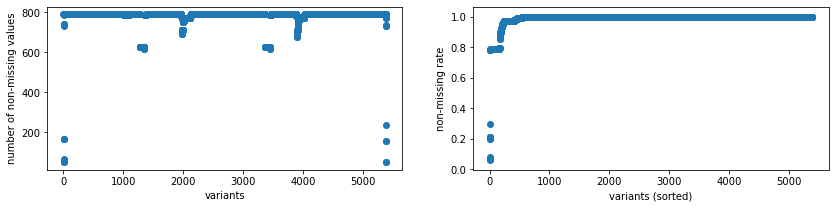

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(14, 3))
# Count the non-missing values
variants_counts = df_aa.count()
r = np.arange(1, len(variants_counts)+1)
# Plot it
ax[0].scatter(x=r, y=variants_counts);
ax[0].set_xlabel('variants'); ax[0].set_ylabel('number of non-missing values')
# Want to sort it
N_ind = df_aa.shape[0]
missing_rates = variants_counts.sort_values()
missing_rates = missing_rates/N_ind
plt.scatter(x=np.arange(1, len(variants_counts)+1), y=missing_rates);
plt.ylabel('non-missing rate'); plt.xlabel('variants (sorted)');

We see that some variables have very few non-NA values *(we should remove them...)*. Let's sort them by the rate of non-missing values, and compute the percentage of missing values for each variable.

### Per individual

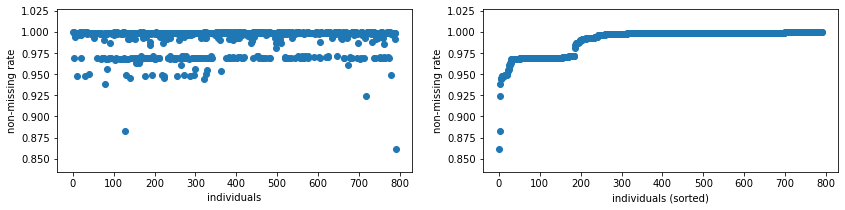

In [9]:

fig, ax = plt.subplots(1, 2, figsize=(14, 3))
# Count non-missing values per individual 
inds_counts = df_aa.count(axis=1)
# Transform counts into frequencies
N_variants = df_aa.shape[1]
inds_counts = inds_counts/N_variants;
# Plot
rng = np.arange(1, len(inds_counts)+1)
ax[0].scatter(x=rng, y=inds_counts);
ax[0].set_xlabel('individuals'); ax[0].set_ylabel('non-missing rate')
ax[1].scatter(x=rng, y=inds_counts.sort_values())
ax[1].set_xlabel('individuals (sorted)'); ax[1].set_ylabel('non-missing rate');

The worst case still has only ~15% of missing values. 

## Mutation rates per INDIVIDUAL

We transpose the DataFrame.

### Plots

In [10]:
dfT = df_aa.transpose()
dfT.drop('index', axis=0, inplace=True)
dfT.head()

,0,1,2,3,4,5,6,7,8,9,...,780,781,782,783,784,785,786,787,788,789
gene_PC_C_pos_0001_I,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,NaN,0,0
gene_PC_C_pos_0001_M,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,NaN,1,1
gene_PC_C_pos_0002_Q,1,1,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
gene_PC_C_pos_0002_R,0,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
gene_PC_C_pos_0002_STOP,0,0,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


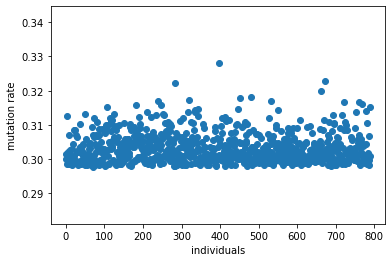

In [11]:
rates = dfT.apply(np.mean)
plt.scatter(x=rates.index, y=rates);
plt.xlabel('individuals')
plt.ylabel('mutation rate');

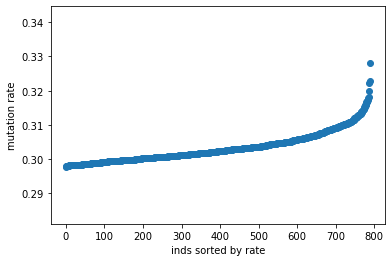

In [12]:
plt.scatter(x=rates.index, y=rates.sort_values());
plt.xlabel('inds sorted by rate')
plt.ylabel('mutation rate');

Note that those rates are ignoring `NaN` values.

### Summary statistics

count    790.000000
mean       0.303379
std        0.004363
min        0.297805
25%        0.300204
50%        0.302260
75%        0.305463
max        0.327945
dtype: float64


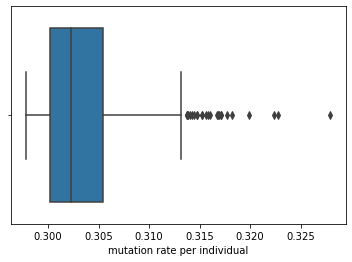

In [13]:
# Summary statistics
print(rates.describe())
# Boxplot
sns.boxplot(rates); plt.xlabel('mutation rate per individual');

### Individuals with higher mutation rates

In [14]:
rates.sort_values(ascending=False).head(10)

397    0.327945
673    0.322786
283    0.322352
662    0.319939
480    0.318217
452    0.317734
320    0.317155
240    0.317129
532    0.316877
721    0.316797
dtype: float64

## Mutation rates per variable/column

Here we look at the rates (mean) of mutations **for each column**, i.e. we treat `gene_XX_pos_YY_Z1` and `gene_XX_pos_YY_Z2` separately.

*Note: intuitively, we would like to apply the computation with `axis=0` (which is the default axis). However, pandas iterates the DataFrame by row, thus we must specify `axis=1` instead.*

In [15]:
# Here, we compute the mean from dtT with axis=1
var_rates = dfT.apply(np.mean, axis=1)
print("Shape =", var_rates.shape)
print("Head (2 items):")
print(var_rates.head(2))
var_rates.describe()

Shape = (5393,)
Head (2 items):
gene_PC_C_pos_0001_I    0.001348
gene_PC_C_pos_0001_M    1.000000
dtype: float64


count    5393.000000
mean        0.303034
std         0.429595
min         0.001266
25%         0.002532
50%         0.010139
75%         0.905072
max         1.000000
dtype: float64

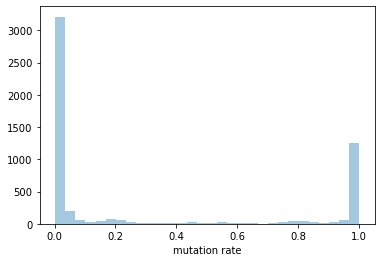

In [16]:
sns.distplot(var_rates, kde=False, bins=30);
plt.xlabel('mutation rate');

We see that most of the variables have very small mutation rate (< 10%) or very high mutation rate (>90%). Let's look at those extremities: 

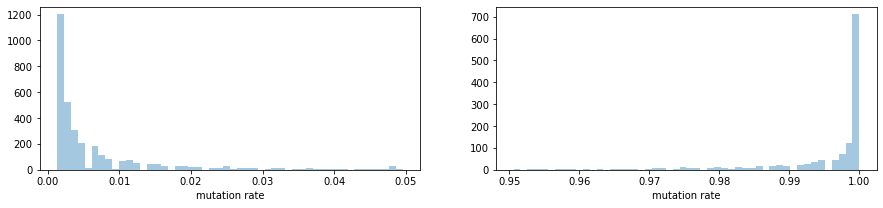

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(15,3))
# Define bounds of extremities
lower_bound = 0.05
upper_bound = 0.95
# Plot histograms
sns.distplot(var_rates[var_rates <= lower_bound], kde=False, ax=ax[0]);
ax[0].set_xlabel('mutation rate')
sns.distplot(var_rates[var_rates >= upper_bound], kde=False, ax=ax[1])
ax[1].set_xlabel('mutation rate');

### Most conserved variants


In [18]:
variants_rate_1 = var_rates[var_rates == 1.0].index.values
print(len(variants_rate_1), "variants with mutation rate of 1.00")
print("Those variants are contained in the following genes:", 
      viral_seq.collapse_variants(variants_rate_1, pos=False))
positions = viral_seq.collapse_variants(variants_rate_1)
print("At a total of {} positions".format(len(positions)))

710 variants with mutation rate of 1.00
Those variants are contained in the following genes: ['gene_PC_C', 'gene_Pol', 'gene_S', 'gene_X']
At a total of 710 positions


## Mutations per position

Here we are interested in the variants that exist in each position. One metric we could get from this is the variance per gene.

**NOTE: we create a DataFrame that uses MultiIndex**.

**WARNING: this is generated before removing NA values. Anyway, not even sure that this table is useful in any way.**

In [59]:
# Make the index as a column
df_pos = dfT.reset_index()
# Process the 'index' column to extract information (gene, position, variant)
df_pos['gene'] = df_pos['index'].apply(lambda s: s.split('_')[1])
df_pos['pos'] = df_pos['index'].apply(lambda s: int(s.split('_')[-2]))
df_pos['variant'] = df_pos['index'].apply(lambda s: s.split('_')[-1])

# Create a MultiIndex with the extracted information
df_pos.set_index(['gene', 'pos', 'variant'], inplace=True)
# 'index' column is useless yet (does not provide any extra information)
df_pos.drop(columns=['index'], inplace=True)
df_pos

0   1    2    3    4    5    6    7    8    9    ...  780  \
gene pos variant                                                  ...        
PC   1   I         0   0    0    0    0    0    0    0    0    0  ...    0   
         M         1   1    1    1    1    1    1    1    1    1  ...    1   
     2   Q         1   1  NaN  NaN  NaN    1  NaN  NaN  NaN  NaN  ...  NaN   
         R         0   0  NaN  NaN  NaN    0  NaN  NaN  NaN  NaN  ...  NaN   
         STOP      0   0  NaN  NaN  NaN    1  NaN  NaN  NaN  NaN  ...  NaN   
...               ..  ..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
X    152 T         1   1  NaN    1  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   
     153 S         1   1    1    1    1    1    1  NaN    1    1  ...    1   
     154 A         1   1    1    1    1    1    1    1    1    1  ...    1   
     155 STOP      1   1    1    1    1    1    1    1    1    1  ...    1   
         W         0   0    0    0    0    0    0    0    0    0  ...    0   

                  781  782  783  784  785  786  787  788 789  
gene pos variant                                              
PC   1   I          0    0    0    0    0    0  NaN    0   0  
         M          1    1    1    1    1    1  NaN    1   1  
     2   Q        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   1  
         R        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   0  
         STOP     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   1  
...               ...  ...  ...  ...  ...  ...  ...  ...  ..  
X    152 T        NaN  NaN  NaN  NaN    1  NaN  NaN  NaN   1  
     153 S          1    1    1  NaN    1    1  NaN    1   1  
     154 A          1    1    1    1    1    1    1    1   1  
     155 STOP       1    1    1    1    1    1    1    1   1  
         W          0    0    0    0    0    0    0    0   0  

[5393 rows x 790 columns]

### Note on multi-indexing

One can basically slice the data structure with tuples, i.e. `('geneX', Y, 'variantZ')`. Example: select the value in gene X, at position 141, variant M:

    df_pos.loc[ ('X', 141, 'M') ]
    
To perform **partial splicing**, one can let items from a tuple empty. Example: select all VARIANTS from gene PC, at position 1

    df_pos.loc[('PC', 1, )]
    
Example: select all POSITIONS from gene PC

    df_pos.loc['PC']

### Group data by position

The goal is to show the number of variants that are present at each position (number of variants with a value of `1`). 

In [31]:
# Warning: this is a slow computation, takes several minutes
# Thus we use a custom 'manage_pickle' function
# We basically load it if the computation has already been done
# Otherwise, we make the calculation and store it into a file. 
def group_by_pos():
    return df_pos.groupby(level=['gene', 'pos']).sum()

df_grouped = common.manage_pickle(path='data/viral_seq_grouped', fun=group_by_pos)
df_grouped

manage_pickle: the file 'data/viral_seq_grouped' has been loaded


0    1    2    3    4    5    6    7    8    9    ...  780  781  \
gene pos                                                    ...             
PC   1    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
     2    1.0  1.0  0.0  0.0  0.0  2.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
     3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
     4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
     5    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
...       ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
X    151  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
     152  1.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
     153  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  ...  1.0  1.0   
     154  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
     155  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   

          782  783  784  785  786  787  788  789  
gene pos                                          
PC   1    1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  
     2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0  
     3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
     4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
     5    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...       ...  ...  ...  ...  ...  ...  ...  ...  
X    151  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
     152  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  
     153  1.0  1.0  0.0  1.0  1.0  0.0  1.0  1.0  
     154  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
     155  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  

[1613 rows x 790 columns]

# Process NaN values

By looking at the plot showing the non-missing values, we see that a few values are below 50%, some are clustered around 80%, and all others lie around 100%. We need to choose a threshold that will lead to exclusion of variants and individuals that have a high rate of missing values.

First, we'll focus on *variants* with high rates of missing values, since we **don't want to loose individuals !**. 

Note: we are working on `df_pos`.

## Drop: missing variants per variant

There are 181 variants (out of 5393) having a missing rate greater than 10.0%
Those variants were dropped ! Remaining: 5212 variants


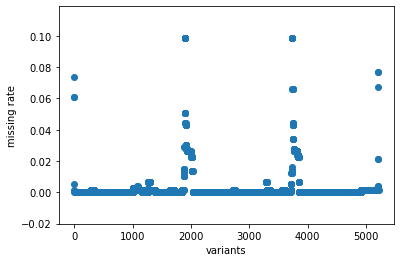

In [60]:
# Define the maximal accepted missing rate (for variants, not individuals)
variants_threshold_max_missing = 0.10

# Counts missing values in the new table
variants_counts = df_pos.count(axis=1)
# Transform into rate/frequency
variants_counts /= df_pos.shape[1]

# Keep only the high-missing rates
# Don't forget variants_counts represent the NON-missing rate
variants_to_drop = variants_counts[ variants_counts <= (1-variants_threshold_max_missing) ]

# Display
print("There are {} variants (out of {}) having a missing rate greater than {}%"
     .format(len(variants_to_drop), df_pos.shape[0], variants_threshold_max_missing*100))

# Drop those values
df_pos.drop(variants_to_drop.index, inplace=True)
print("Those variants were dropped ! Remaining: {} variants".format(df_pos.shape[0]))

# We plot the missing rates rather than the non-missing rates
plt.scatter(x=np.arange(1,df_pos.shape[0]+1), 
                y=(1-df_pos.count(axis=1)/df_pos.shape[1]));
plt.xlabel("variants"); plt.ylabel("missing rate");

## Drop missing variants per individuals

The threshold is defined in `src/setup.py` as `INDIVIDUALS_THRESHOLD_MAX_MISSING`.

There are 1 individuals with a missing rate greater than 10.0%.
Those individuals were dropped ! Remaining: 789


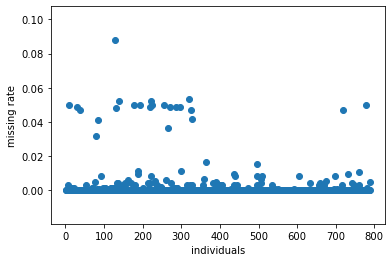

In [61]:
# Count the non-NaN values per individual
inds_missing_freq = df_pos.count(axis=0)
inds_missing_freq /= df_pos.shape[0]

# Transform NON-missing rate to missing rate
inds_missing_freq = 1-inds_missing_freq

# Indexes to drop
inds_to_drop = inds_missing_freq[ inds_missing_freq >= setup.INDIVIDUALS_THRESHOLD_MAX_MISSING ]
inds_to_drop = inds_to_drop.index
print("There are {} individuals with a missing rate greater than {}%."
     .format(len(inds_to_drop), setup.INDIVIDUALS_THRESHOLD_MAX_MISSING*100))

# Drop the values
df_pos.drop(inds_to_drop, axis=1, inplace=True)
print("Those individuals were dropped ! Remaining: {}".format(df_pos.shape[1]))

plt.scatter(x=np.arange(1, df_pos.shape[1]+1), y=(1-df_pos.count()/df_pos.shape[0]))
plt.xlabel('individuals'); plt.ylabel('missing rate');

# Drop omnipresent and absent variants

In the mutation rate plots, we saw that many variants are omnipresent or completely absent. We want to get rid of them since they do not give any information, or we don't have enough statistical power to detect the very rare variants (something to do with the integrity of the model).  

We must define a threshold: this will apply on both sides (both high and low occuring rates). **We drop the values in the `df_pos` DataFrame**.

## Investigate the number of lost variables

In [63]:
def compute_to_drop_ids(rates, threshold):
    # Filter this out to keep to omnipresent or absent variants
    to_drop_ids = rates[rates <= threshold].index
    to_drop_ids.append(rates[rates >= (1-threshold)].index)
    return to_drop_ids

In [64]:
# Compute the mutation rates
var_rates = df_pos.apply(np.mean, axis=1)

print("Threshold\tLost values")

# Compare with multiple thresholds
thresholds = [0.1, 0.05, 0.01, 0.005]
for T in thresholds :
    ids = compute_to_drop_ids(var_rates, T)
    print(T, "\t\t", len(ids))
print("\nOut of", len(var_rates), "in total.")

Threshold	Lost values
0.1 		 3325
0.05 		 3206
0.01 		 2582
0.005 		 2003

Out of 5212 in total.


## Choose threshold and drop

We will choose a threshold of 10% (defined in `src/setup.py`). 

In [69]:
# We use the function compute_to_drop_ids and the var_rates computed above
rare_variants_to_drop = compute_to_drop_ids(var_rates, setup.VARIANTS_THRESHOLD_FREQUENCY)
print("There are {} variants with a frequency < {}% or > {}% (out of {})."
     .format(len(rare_variants_to_drop), setup.VARIANTS_THRESHOLD_FREQUENCY*100,
            (1-setup.VARIANTS_THRESHOLD_FREQUENCY)*100, df_pos.shape[0] ))

# Drop those values
df_pos.drop(rare_variants_to_drop, inplace=True, axis=0)

print("Those were dropped ! Remaining: {}".format(df_pos.shape[0]))

There are 3206 variants with a frequency < 5.0% or > 95.0% (out of 5212).
Those were dropped ! Remaining: 2006


# PCA

See https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

Attributes of the sklearn PCA object are:
* components_
* explained_variance_
* explained_variance_ratio_
* singular_values_
* ...

See in the Statistics notebook the methods to choose the number of principal components, with the **'scree plot' and the elbow rule**. Note that without modifying the size, the **plot is biased**, as said in *Ten quick tips for effective dimensionality reduction, Tip 6: Apply the correct aspect ratio for visualizations* :
> The DR plots should obey the aspect ratio consistent with the relative amount of information explained by the output axes displayed. In the case of PCA, each output dimension has a corresponding eigenvalue proportional to the amount of variance it explains. 

## Imputation of missing values

See https://datascience.stackexchange.com/a/11933. One possible thing is to impute missing values, see [SimpleImputer](https://scikit-learn.org/stable/modules/impute.html#impute) of sklearn. There are several strategies (mean, median, most_frequent, ...).

Also there is a MultipleImputer, which uses several variables to impute the data.

We'll compare two different strategies: mean and most frequent.

### Example

In [24]:
# Impute missing values
#imputer = SimpleImputer()
#data = [ [0,1, 2], [1, 2, 3], [np.nan, 1, -1] ]
#data = pd.DataFrame(data)
#print(data)
#imputer.fit_transform(data)

We see that the imputation happens by columns. Thus we'll use the transpose of the multiindex DataFrame (now managed in a script). 

## PCA and simple imputation

### Strategy: mean

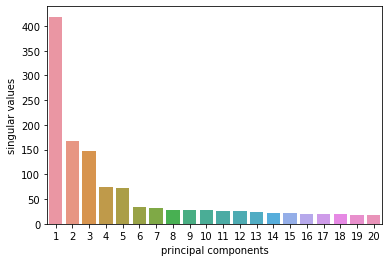

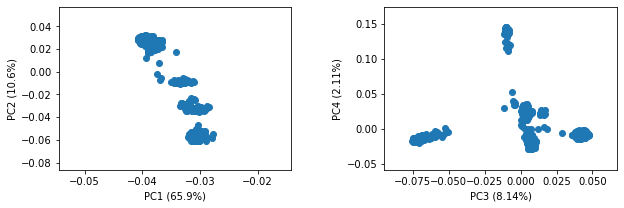

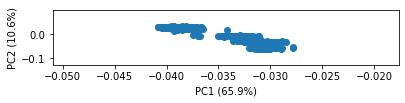

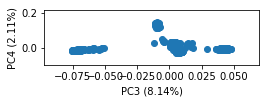

In [74]:
pcs = viral_seq.pca_impute(df=df_pos, n_components=20, impute_strategy='mean')
common.plot_pca(pcs, pc_plot_height=1, n_plots=2)

### Strategy: 'most_frequent'



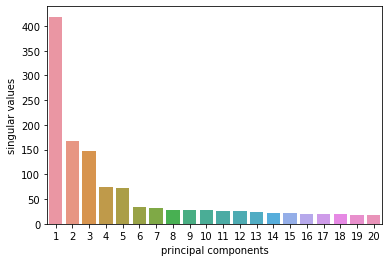

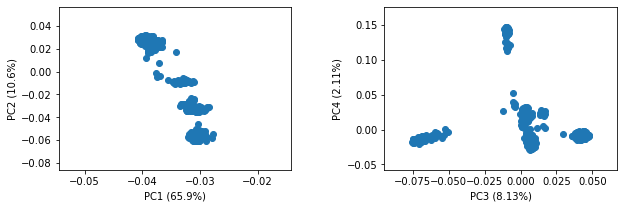

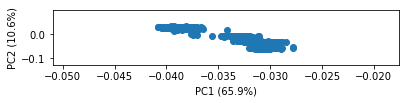

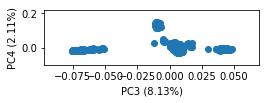

In [77]:
pcs = viral_seq.pca_impute(df=df_pos, n_components=20, impute_strategy='most_frequent')
common.plot_pca(pcs, pc_plot_height=1, n_plots=2)

We actually see no changes compared with the strategy of the mean. 

## PCA and IterativeImputer

IterativeImputer is still at experimental step. 

Note: IterativeImputer takes many parameters. We only provide `min_value` and `max_value` (respectively 0 and 1).

**Warning: this overfills the entire memory on the laptop... Try on scitas**.

In [27]:
#pcs = viral_seq.pca_impute(df=df_pos, n_components=20, impute_strategy='iterative')

# Finalization

We want to store the clean and processed DataFrame, whith the IDs.

In [73]:
df_store = df_pos.transpose()
df_store.insert(value=df_aa['index'], column='id', loc=0)

# use custom function to write in a file:
common.write_binary(setup.PATH_VIRAL_DATA, df_store)

print("\nThe final data shape is", df_store.shape)

write_binary(): successfully written in 'data/viral_data'

The final data shape is (789, 2007)
